In [ ]:
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


The network architecture of RetinaNet

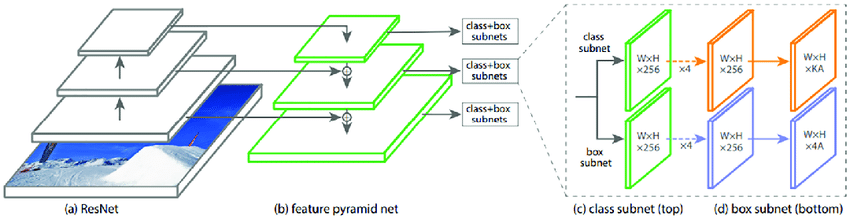

Install Requirements

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ywfb869q
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ywfb869q
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266989 sha256=051774f75e22c153bcc9d66d850281028879da0bbfac50143b73653fd1b8aead
  Stored in directory: /tmp/pip-ephem-wheel-cache-5tq3aow_/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


Download Subset of COCO Dataset
(val2017 COCO dataset having 5000 images)

In [ ]:
import os
os.mkdir('/content/data')
%cd data
!cp /content/drive/My\ Drive/instances_val2017.json /content/data/coco_dataset.json
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
%cd ../

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/00000037

Take set of dataset for Training, Validation and Testing of RetinaNet implementation

In [ ]:
import json
import os
import shutil
# split factor for validation and testing is same
# if split_factor is 0.9 then 90 % train, 5% validation, 5% test

def create_dataset(coco_json_path, split_factor, percentage_dataset):

  data = json.load(open(coco_json_path))
  #os.mkdir('/content/data')                                          # data folder is created

  #percentage of dataset that you have to consider for train, val and test
  length_dataset = int(len(data['annotations']) * percentage_dataset / 100) 
  end_train = int(length_dataset * split_factor)

  for process in ['train','val','test']:

    if process == 'train':
      start = 0
      end = end_train - 1
    
    elif process == 'val' : 
      start = end_train
      end = start + int((100-split_factor*100)/200 * length_dataset) - 1
    
    elif process == 'test' :
      start = start + int((100-split_factor*100)/200 * length_dataset)
      end = length_dataset - 1

    print(process, start, end)
    image_id = []
    for i in data['annotations'][start:end]:
      image_id.append(i['image_id'])
    imgs = []
    images_details = []
    [imgs.append(x) for x in image_id if x not in imgs]
    for i in imgs:
      for j in data['images']:
        if j['id'] == i:
          imgs[imgs.index(i)] = data['images'][data['images'].index(j)]['file_name']
          images_details.append(j)
          break

    outputs = {}

    outputs['images'] = images_details
    outputs['annotations'] = data['annotations'][start:end]
    outputs['categories'] = data['categories']

    if process == 'test':
      images_folder = '/content/data/' + process + '_images'
      os.mkdir(images_folder)

      for i in outputs['images']: 
        shutil.copyfile(os.path.join('/content/data/val2017', i['file_name']), os.path.join(images_folder, i['file_name']))

    # write json file
    json_file = '/content/data/' + process + '_coco_dataset.json'
    json.dump(outputs, open(json_file, 'w'))

In [ ]:
# split coco dataset into train, validation and testing
coco_json_path = '/content/data/coco_dataset.json'
split_factor = 0.7
# here consider 10% dataset for split into train, val and test
percentage_dataset = 10                

create_dataset(coco_json_path, split_factor, percentage_dataset)

train 0 2573
val 2574 3124
test 3125 3677


Clone repository of RetinaNet Implementation

In [ ]:
!git clone https://github.com/ganeshkulkarni98/retinanet

Cloning into 'retinanet'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 38), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [ ]:
%cd retinanet

/content/retinanet


ResNet (Backbone) pretrained weights (Trained on ImageNet Dataset)

In [ ]:
# !wget https://download.pytorch.org/models/resnet18-5c106cde.pth
# !wget https://download.pytorch.org/models/resnet34-333f7ec4.pth
# !wget https://download.pytorch.org/models/resnet50-19c8e357.pth
# !wget https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
# !wget https://download.pytorch.org/models/resnet152-b121ed2d.pth

--2020-06-19 18:47:38--  https://download.pytorch.org/models/resnet18-5c106cde.pth
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.64, 99.86.33.87, 99.86.33.48, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46827520 (45M) [application/octet-stream]
Saving to: ‘resnet18-5c106cde.pth’

resnet18-5c106cde.p 100%[===================>]  44.66M   224MB/s    in 0.2s    

2020-06-19 18:47:38 (224 MB/s) - ‘resnet18-5c106cde.pth’ saved [46827520/46827520]

--2020-06-19 18:47:41--  https://download.pytorch.org/models/resnet34-333f7ec4.pth
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.64, 99.86.33.87, 99.86.33.48, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87306240 (83M) [application/octet-stream]
Saving to: ‘resnet34-333f7ec4.pth’

resnet34-333f7ec4.p 100%[

RetinaNet model pretrained weight (Trained on COCO dataset) : https://drive.google.com/file/d/1-9UHb7cDcgiPdjrbhG93ooGHBvFYCu1F/view?usp=sharing

In [ ]:
!cp /content/drive/My\ Drive/retinanet50_pretrained.pth /content/retinanet/retinanet50_pretrained.pth

# **Run Train function**

Train Case 1

I have trained model using pretrained weight file

    weight_file_path = '/content/retinanet/retinanet50_pretrained.pth'

In [ ]:
!python train.py

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
CUDA available: True
model initialized..
Number of training images: 160 Number of validation images: 35
Training dataset
Epoch: 0 | Iteration: 0 | Classification loss: 0.80326 | Regression loss: 0.36780 | Running loss: 1.17106
Epoch: 0 | Iteration: 1 | Classification loss: 14.59980 | Regression loss: 0.28689 | Running loss: 8.02887
Epoch: 0 | Iteration: 2 | Classification loss: 0.74806 | Regression loss: 0.33188 | Running loss: 5.71256
Epoch: 0 | Iteration: 3 | Classification loss: 8.75851 | Regression loss: 0.47324 | Running loss: 6.59236
Epoch: 0 | Iteration: 4 | Classification loss: 2.05031 | Regression loss: 0.33468 | Running loss: 5.75089
Epoch: 0 | Iteration: 5 | Classification loss: 6.02974 | Regression loss: 0.22210 | Running loss: 5.83438
Epoch: 0 | Iteration: 6 | Classification loss: 1.10651 | Regression loss: 0.

# **Run Test function**

Test Case 1

I have tested model using pretrained weight file

    weight_file_path = '/content/retinanet/retinanet50_pretrained.pth'

Detect Case

    weight_file_path = '/content/ssd/SSD300_pretrained_weight.pth'  (path to pretrained weights)

In [ ]:
!python test.py

CUDA available: True
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
model initialized..
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.765
 Average Recall     (AR)

# **Run Detection function**

Detect Case : 

    weight_file_path = '/content/retinanet/retinanet50_pretrained.pth'

In [ ]:
!python detect.py

Streaming output truncated to the last 5000 lines.
       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8), array([[[238, 236, 219],
        [223, 221, 206],
        [187, 186, 174],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[242, 239, 224],
        [227, 225, 211],
        [191, 189, 178],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[246, 244, 230],
        [231, 228, 216],
        [194, 192, 183],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
  